# Project: Part of Speech Tagging with Hidden Markov Models 
---
### Introduction

Part of speech tagging is the process of determining the syntactic category of a word from the words in its surrounding context. It is often used to help disambiguate natural language phrases because it can be done quickly with high accuracy. Tagging can be used for many NLP tasks like determining correct pronunciation during speech synthesis (for example, _dis_-count as a noun vs dis-_count_ as a verb), for information retrieval, and for word sense disambiguation.

In this notebook, we use the [Pomegranate](http://pomegranate.readthedocs.io/) library to build a hidden Markov model for part of speech tagging using a "universal" tagset. Hidden Markov models have been able to achieve [>96% tag accuracy with larger tagsets on realistic text corpora](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf). Hidden Markov models have also been used for speech recognition and speech generation, machine translation, gene recognition for bioinformatics, and human gesture recognition for computer vision, and more. 

This is a supervised machine learning project where known part of speech tags are provided for building trained models.

###  Implementation Notes

This notebook uses version Python 3.  
It loads the brown corpus from NLTK into pandas.  
It does not use the recommended helper class for natural language processing.  
For educational purposes, this code is not written for coding efficiency.  
This may run slower than other implementations as a trade-off.

### (1) Import tools and data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from IPython.core.display import HTML

from pomegranate import *
import random
import math
random.seed(0)

import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown
from nltk import bigrams

from matplotlib_venn import venn2
from sklearn.metrics import confusion_matrix
from sklearn import metrics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


### (2) Explore the data structure.

In [2]:
# reveal the categories of the corpus
categories = brown.categories()
print(categories)

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


In [3]:
# build dataframe for the brown corpus
fileids = brown.fileids()
bcn = []
bwt = []
bps = []
for file in fileids:
    for sentence in brown.tagged_sents(tagset='universal', fileids = [file]):
        bcn.append(brown.categories(fileids = [file])[0])
        wrds = []
        tags = []
        for tup in sentence:
            wrds.append(tup[0])
            tags.append(tup[1])
        bwt.append(wrds)
        bps.append(tags)
    
data = pd.DataFrame({'category':bcn,'words':bwt, 'pos_target':bps})
data.index.name = 'b100'
data.head()    

,category,words,pos_target
b100,,,
0,news,"[The, Fulton, County, Grand, Jury, said, Frida...","[DET, NOUN, NOUN, ADJ, NOUN, VERB, NOUN, DET, ..."
1,news,"[The, jury, further, said, in, term-end, prese...","[DET, NOUN, ADV, VERB, ADP, NOUN, NOUN, ADP, D..."
2,news,"[The, September-October, term, jury, had, been...","[DET, NOUN, NOUN, NOUN, VERB, VERB, VERB, ADP,..."
3,news,"[``, Only, a, relative, handful, of, such, rep...","[., ADV, DET, ADJ, NOUN, ADP, ADJ, NOUN, VERB,..."
4,news,"[The, jury, said, it, did, find, that, many, o...","[DET, NOUN, VERB, PRON, VERB, VERB, ADP, ADJ, ..."


In [4]:
# verify the dataframe size as the number of sentences
print('Brown Corpus has {} sentences.'.format(len(data)))

Brown Corpus has 57340 sentences.


In [5]:
#number of words in brown is the total words in test and train
nbw = len(brown.words())
print('Brown Corpus contains {} word occurances.'.format(nbw))

Brown Corpus contains 1161192 word occurances.


In [6]:
#number of unique words in brown
ubw = len(set(brown.words()))
print('Brown Corpus has a vocabulary of {} unique words.'.format(ubw))

Brown Corpus has a vocabulary of 56057 unique words.


### (3) Split the data into training and testing sets.

In [7]:
# do a 'stratified' train-test split on the sentances
# assume language use differs between category genre
df_train,df_test = train_test_split(data, stratify=data['category'], test_size=0.20, random_state=13)

In [8]:
print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(df_train)))
print("There are {} sentences in the testing set.".format(len(df_test)))

assert len(data) == len(df_train) + len(df_test), \
       "The number of sentences in the training set + testing set should sum to the number of sentences in the corpus"
HTML('<div class="alert alert-block alert-success">Our test and train data is ready to go!</div>')

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


### (4) Compute one word 'unigram' probabilities.

We use part of this to convert emission counts to emission probabilities.

In [9]:
# build count-dictionary of word tokens using train data
# assumes words are independant like a bag of words
swc = Counter()
for _,nrows in df_train.iterrows():
    # add start tag
    swc['<start>'] += 1
    # add sentence tags
    for tag in nrows['words']:
        swc[tag.lower()] += 1
    # add end tuple
    swc['<end>'] += 1

In [10]:
# total train words
# omit start and end tags
tot_train_words = sum(swc.values()) - (2*len(df_train))
tot_train_words

928792

In [11]:
# build the uni-gram probability function
# assumes word independance like a bag of words
def prb_sw(word):
    # make sure it's lower case
    wordlow = word.lower()
    # add one to smooth for an unknown word
    tot_words = tot_train_words + 1
    if wordlow in swc:
        freq = swc[wordlow]
    else:
        #unknown entry 
        freq = 1/tot_words
    return freq/tot_words

In [12]:
# test it out
prb_sw('the')

0.060187792112989656

### (5) Compute single tag probabilities.

In [13]:
# build count-dictionary of pos tags using train data
# assumes tags are independant like a bag of tags
stc = Counter()
for _,nrows in df_train.iterrows():
    # add start tag
    stc['<START>'] += 1
    # add sentence tags
    for tag in nrows['pos_target']:
        stc[tag] += 1
    # add end tuple
    stc['<END>'] += 1

In [14]:
# total number of tags in training set
# excluding the start and end tags
ugt_train_tot = sum(stc.values()) - (2*len(df_train))
ugt_train_tot

928792

In [15]:
# build a single tag probability function
def prb_st(tag):
    # add one to smooth for an unknown tag
    tot_stc = ugt_train_tot + 1
    if tag in stc:
        freq = stc[tag]
    else:
        #highly unlikely unknown tag 
        freq = 1/tot_stc
    return freq/tot_stc

In [16]:
assert len(set(stc.keys())) >= 12, \
       "Uh oh. It looks like your tag counts doesn't include all the tags!"
assert min(stc, key=stc.get) == 'X', \
       "Hmmm...'X' is expected to be the least common class"
assert max(stc, key=stc.get) == 'NOUN', \
       "Hmmm...'NOUN' is expected to be the most common class"
HTML('<div class="alert alert-block alert-success">Your tag unigrams look good!</div>')

### (6) Program the emission probability function.

In [17]:
# confirm there are twelve entries for parts of speach
# bps is our big list of lists of brown pos tags
pos_types = sorted(list(set([y for x in bps for y in x])))
print(pos_types)
print('number of unique pos tags = {}'.format(len(pos_types)))

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
number of unique pos tags = 12


This is used downstream to remember all the tag types.

In [18]:
# reveal 'NOUN' as the most frequent tag
print(pos_types)
print([stc[i] for i in pos_types])

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
[118162, 66836, 115565, 45015, 30579, 109610, 220369, 11858, 39494, 23917, 146277, 1110]


In [19]:
#build dictionary for pos to word emission probabilities
def p_to_w(df):
    posword = defaultdict(Counter)
    # upstream dividing by total counts
    inc = 1 / tot_train_words
    for i,nrows in df.iterrows():
        for num, wrd in enumerate(nrows['words']):
            posword[nrows['pos_target'][num]][wrd.lower()] += inc
    return posword   

In [20]:
#build the probability dictionary out of train data
emission_counts = p_to_w(df_train)

In [21]:
# these are probabilities, not counts
emission_counts['DET']['the']

0.06018462691323978

In [22]:
assert len(emission_counts) == 12, \
       "Uh oh. There should be 12 tags in your dictionary."
assert emission_counts["NOUN"].most_common()[0][0] == 'time', \
       "Hmmm...'time' is expected to be the most common NOUN."
HTML('<div class="alert alert-block alert-success">Your emission counts look good!</div>')

In [23]:
# Add dummy tags to flag start and ends for iterrating sentences
emission_counts['<END>']['<end>'] = len(df_train) / tot_train_words
emission_counts['<START>']['<start>'] = len(df_train) / tot_train_words

### (7) Build dictionaries for taggers.

In [24]:
# build count-dictionary for word to pos counts
def w_to_p(df):
    wordpos = defaultdict(Counter)
    for i,nrows in df.iterrows():
        for num, wrd in enumerate(nrows['words']):
            wordpos[wrd.lower()][nrows['pos_target'][num]] += 1
    return wordpos

#build the count-dictionary from the train data
wtp_train = w_to_p(df_train)

In [25]:
# add dummy tags to dictionary for iterrating sentances
wtp_train['<end>']['<END>'] = len(df_train) / tot_train_words
wtp_train['<start>']['<START>'] = len(df_train) / tot_train_words

### (8) Visualize word data using Venn diagrams.

In [26]:
# check the vocabulary size of the training set
vocab_train = len(wtp_train)
vocab_train

45078

In [27]:
# check the vocabulary size of the testing set
wtp_test = w_to_p(df_test)
vocab_test = len(wtp_test)
vocab_test

22786

In [28]:
# number of words intersected by training and testing set vocabularies
vocab_join = sum([int(k in wtp_test) for k in wtp_train])
vocab_join

18047

In [29]:
# number of words mutually exclusive in training and testing set vocabularies
vocab_out = sum([int(k not in wtp_train) for k in wtp_test])
vocab_out

4739

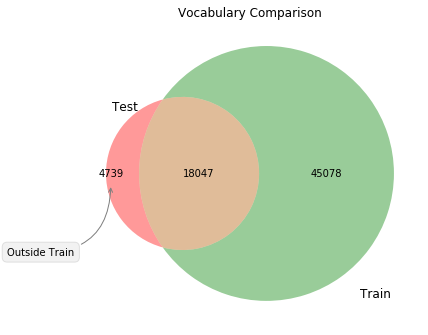

In [30]:
# make a Venn diagram of the vocabulary
plt.figure(figsize=(6,6))
v = venn2(subsets = (vocab_out, vocab_train, vocab_join))
plt.title("Vocabulary Comparison")
p0 = v.get_label_by_id('10').get_position()
v.get_label_by_id('10').set_position([p0[0]-0.05, p0[1]+0.0])
v.get_label_by_id('A').set_text('Test')
p1 = v.get_label_by_id('B').get_position()
v.get_label_by_id('A').set_position([p1[0]-0.55, p1[1]+0.9])
v.get_label_by_id('B').set_text('Train')
p2 = v.get_label_by_id('B').get_position()
v.get_label_by_id('B').set_position([p2[0]+0.4, p2[1]+0.1])
plt.annotate('Outside Train', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()

The test set outcast words can catalyze transition and emission errors in HMM models.

In [31]:
# find the number of times the outcast words occur in test set
outwords = []
for key in wtp_test:
    if key not in wtp_train:
        outwords.append(key)

t_count = 0
o_count = 0
s_count = 0
for _,nrows in df_test.iterrows():
    for word in nrows['words']:
        if word.lower() in outwords:
            o_count +=1
        t_count +=1
    s_count +=1
        
print('test outcast word occurance count = ',o_count)
print('test word count = ', t_count)
print('test sentence count = ', s_count)
print('fraction test words not in train set = ',\
      round(o_count/t_count,3)) 

test outcast word occurance count =  5155
test word count =  232400
test sentence count =  11468
fraction test words not in train set =  0.022


The ~2% outcast words may cause more than 2% irreducible error in tagging accuracy.  
This is because they impact both emission and transition probabilities.  
This seems to act as a ceiling for the accuracy figure.

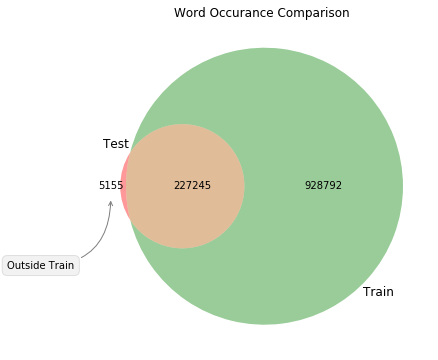

In [32]:
# make a Venn diagram of the word occurance
plt.figure(figsize=(6,6))
v = venn2(subsets = (o_count, nbw-t_count, t_count-o_count))
plt.title("Word Occurance Comparison")
p1 = v.get_label_by_id('10').get_position()
v.get_label_by_id('10').set_position([p1[0]-0.05, p1[1]+0.0])
p2 = v.get_label_by_id('11').get_position()
v.get_label_by_id('11').set_position([p2[0]+0.03, p2[1]+0.0])
v.get_label_by_id('A').set_text('Test')
p3 = v.get_label_by_id('B').get_position()
v.get_label_by_id('A').set_position([p3[0]-0.55, p3[1]+0.8])
v.get_label_by_id('B').set_text('Train')
p4 = v.get_label_by_id('B').get_position()
v.get_label_by_id('B').set_position([p4[0]+0.4, p4[1]+0.2])

plt.annotate('Outside Train', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()

The Test / Train split presents an everpresent outcast word problem.  
This seems a consequence of random test train splits.  

In [33]:
print("There are a total of {} samples of {} unique words in the corpus."
      .format(nbw, ubw))
print("There are {} samples of {} unique words in the training set."
      .format(tot_train_words, vocab_train))
print("There are {} samples of {} unique words in the testing set."
      .format(t_count, vocab_test))
print("There are {} unique words in the test set that are missing in the training set."
      .format(vocab_out))

assert nbw == ugt_train_tot + t_count, \
       "The number of training + test samples should sum to the total number of samples"

There are a total of 1161192 samples of 56057 unique words in the corpus.
There are 928792 samples of 45078 unique words in the training set.
There are 232400 samples of 22786 unique words in the testing set.
There are 4739 unique words in the test set that are missing in the training set.


### (9) Make predictions with the MFC model.

In [34]:
# build function to return most frequent class tag
def mfc_tag(word):   
    #convert word to lowercase
    wordlow = word.lower()
    #check if unknown
    if (wordlow in wtp_train):
        # if empty assign most frequent tag
        if (wtp_train[wordlow] == Counter()):
            tag = 'NOUN'  
        # word is known and has counts
        else:
            tag = (wtp_train[wordlow].most_common()[0][0])     
    # word is not in the count-dictionary        
    else:
        # drop in the most common tag
        tag = 'NOUN'
    return tag

In [35]:
# turn pandas warning off
pd.options.mode.chained_assignment = None

# append dataframe with mfc-prediction lists
def make_pred(df):
    pred_test = []
    for i,nrows in df.iterrows():
        pred_pos = []
        for word in nrows['words']:
            pred_pos.append(mfc_tag(word))
        pred_test.append(pred_pos)
    df['mfc_pred'] = pred_test
    
#update the train and test dataframes
make_pred(df_train)
make_pred(df_test)

#view some of a dataframe
df_train.head()

,category,words,pos_target,mfc_pred
b100,,,,
41158,fiction,"[Beckworth, left, the, tent, .]","[NOUN, VERB, DET, NOUN, .]","[NOUN, VERB, DET, NOUN, .]"
16955,lore,"[When, Hudson, had, finished, ,, the, ``, town...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,..."
2557,news,"[The, World, War, 2, ,, German, bomber, rolled...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, ADP...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, PRT..."
57080,humor,"[``, Arlene's, a, good, girl, '', ,, my, uncle...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB..."
6751,editorial,"[There's, no, sense, in, being, reminded, of, ...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, P...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, A..."


In [36]:
assert len(wtp_train) == vocab_train, ""
assert all(k in wtp_train for k in wtp_train), ""
assert sum(int(k not in wtp_train) for k in wtp_test) == vocab_out, ""
HTML('<div class="alert alert-block alert-success">Your MFC tagger has all the correct words!</div>')

### (10) Compute MFC prediction accuracy.
We itterate through the dataframe rows and compare values.

In [37]:
# compare actual and predicted part of speech lists
def accuracy(df, ref, pred):
    correct = 0
    count = 0
    for i,nrows in df.iterrows():
        correct += len([x for x, y in zip(nrows[ref], nrows[pred]) if x == y])
        count += len(nrows['words'])
    return correct/count     

In [38]:
mfc_training_acc = accuracy(df_train, 'pos_target','mfc_pred')
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(df_test, 'pos_target','mfc_pred')
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))

assert mfc_training_acc >= 0.955, "Uh oh. Your MFC accuracy on the training set doesn't look right."
assert mfc_testing_acc >= 0.925, "Uh oh. Your MFC accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your MFC tagger accuracy looks correct!</div>')

training accuracy mfc_model: 95.58%
testing accuracy mfc_model: 94.47%


### (11) Compute double part of speach tag or 'bigram tag' probabilities.

In [39]:
# build count-dictionary for bigram tag tuples
# assume tags are co-located
# start and end events are integrated
btc = Counter()
# itterate through tags
for _,nrows in df_train.iterrows():
    start = ('<START>', nrows['pos_target'][0])
    end = (nrows['pos_target'][-1], '<END>')
    # add start tuple
    btc[start] += 1
    # add bigram tuples
    for tup in list(bigrams(nrows['pos_target'])):
        btc[tup] += 1
    # add end tuple
    btc[end] += 1

In [40]:
# total number of bigram tags
# without the start and end tag entries
bgt_train_tot = sum(btc.values()) - (2*len(df_train))
bgt_train_tot

882920

In [41]:
# build a bigram tag probability function
# assumes co-location of two words in tuple
def prb_bt(tup):
    # add one to smooth for an unknown tuple
    tot_btc = bgt_train_tot + 1
    if tup in btc:
        freq = btc[tup]
    else:
        #unknown entry 
        freq = 1/tot_btc
    return freq/tot_btc

In [42]:
assert len(set(btc)) >= 144, \
       "Uh oh. There should be 144 pairs of bigrams (12 tags x 12 tags)"
assert min(btc, key=btc.get) in [('NUM','X'), ('X', 'NUM'), ('PRON', 'X'),('X','<END>')], \
       "Hmmm...The least common bigram should be one of ('X', 'NUM') or ('PRON', 'X')."
assert max(btc, key=btc.get) in [('DET', 'NOUN')], \
       "Hmmm...('DET', 'NOUN') is expected to be the most common bigram."
HTML('<div class="alert alert-block alert-success">Your tag bigrams look good!</div>')

### (12) Build two-word 'bigram' probabilities.

In [43]:
# build a bigram word count dictionary using training data
bwc = Counter()
for _,nrows in df_train.iterrows():
    start = ('<start>', nrows['words'][0])
    end = (nrows['words'][-1], '<end>')
    # add start tuple
    bwc[start] += 1
    # add bigram tuples
    for tup in list(bigrams(nrows['words'])):
        bwc[tup] += 1
    # add end tuple
    bwc[end] += 1  

In [44]:
# count how many word bigrams there are in the training data 
bgw_train_tot = sum(bwc.values()) - (2*len(df_train))
bgw_train_tot

882920

In [45]:
# build a bigram word probability function
def prob2(tup):
    # add one to laplacian smooth for an unknown word
    if tup in bwc:
        freq = bwc[tup]
    else:
        #unknown unlikely entry 
        freq = 1/bgw_train_tot
    return freq/(bgw_train_tot +1)

### (13)  Calculate tag start probabilities. 

In [46]:
# build a dictionary from a dictionary
tsp = Counter()
for tag in pos_types:
    #normalize to all possible starts
    tsp[tag] = prb_bt(('<START>',tag)) * bgt_train_tot / len(df_train)

In [47]:
# verify probabilities add to 1
sum(tsp.values())

0.9999988673958372

In [48]:
assert len(tsp) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tsp, key=tsp.get) == 'X', "Hmmm...'X' is expected to be the least common starting bigram."
assert max(tsp, key=tsp.get) == 'DET', "Hmmm...'DET' is expected to be the most common starting bigram."
HTML('<div class="alert alert-block alert-success">Your starting tag counts look good!</div>')

### (14) Calculate tag end probabilities.

In [49]:
# build tag end dictionary from bigram tag dictionary
tep = Counter()
for tag in pos_types:
    #normalize to all possible ends
    tep[tag] = prb_bt((tag,'<END>')) * bgt_train_tot / len(df_train)

In [50]:
# confirm they total to 1
sum(tep.values())

0.9999988673958371

In [51]:
assert len(tep) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tep, key=tep.get) in ['X', 'CONJ'], "Hmmm...'X' or 'CONJ' should be the least common ending bigram."
assert max(tep, key=tep.get) == '.', "Hmmm...'.' is expected to be the most common ending bigram."
HTML('<div class="alert alert-block alert-success">Your ending tag counts look good!</div>')

### (15) Build Lazy Hidden Markov Model Tagger.  
The lazy term relates to only predicting once left to right through the sequence,  
and then only itterating through known combinations seen in the training set.  
This is adapted from the approach taught in class.

In [52]:
# build emission and transition probability product function
# transition is from prior tag to now tag
# emission is from now tag to now word
def prb_prd(t_prior, t_now, w_now):
    # prior-now tag transition probability
    pt = prb_bt((t_prior,t_now)) 
    # tag-word emission probability
    pe = emission_counts[t_now][w_now.lower()]
    # return product
    return pt * pe

In [53]:
# build function to find most likely tag from the tag prior
# this is used when no tags are found for a given unknown word
def unk_tag(t_prior):
    # initialize to find max probability
    p = 0
    tmx = ''
    # search through all possible pairings
    for tag in pos_types:
        # retrieve the probability
        pbt = prb_bt((t_prior,tag))
        # test if it is the maximum ever seen
        if (pbt > p):
            tmx = tag
            p = pbt
    return tmx

In [54]:
# build part of speach tag predition function
def pos_pred(t_prior, w_now):
    
    #initialize max function
    p = 1
    pmax = 0
    tag_pred = ''
    
    #retreive list of possible now-word pos-tags
        #assume others unlikely for speed
        #this is where the term 'lazy' comes in
        #because it does not check all possibilities
    t_now = list(wtp_train[w_now.lower()].keys())
    #check if list is empty via unknown word
    if (t_now ==[]):
        #if unknown use most probable from prior tag
        return unk_tag(t_prior)
    
    else:   
        # find maximum probability path
        # lazy as looking at only seen possibilities
        for tag in t_now:
            # past transition-emission prob product
            p1 = prb_prd(t_prior, tag, w_now) 
            if p1 > pmax:
                tag_pred = tag
                pmax = p1
                    
    return tag_pred  

In [55]:
# test the function predict tag for middle enty
pos_pred('NOUN','worked')

'VERB'

The function worked for the verb 'worked'.

In [56]:
# build predicted pos list for a sentence
def pos_sen(wordlist):
    t_prior = '<START>'
    p_list = []
    for i in range(len(wordlist)):
        pretag = pos_pred(t_prior, wordlist[i])
        t_prior = pretag
        p_list.append(pretag)
    return p_list      

In [57]:
# append dataframe with lazy-prediction lists
def hmm_pred(df):
    pred_test = []
    for _,nrows in df.iterrows():
        pred_test.append(pos_sen(nrows['words']))
    df['lzy_pred'] = pred_test
    
#update the train and test dataframes
hmm_pred(df_train)
hmm_pred(df_test)

#view some of a dataframe
df_train.head()

,category,words,pos_target,mfc_pred,lzy_pred
b100,,,,,
41158,fiction,"[Beckworth, left, the, tent, .]","[NOUN, VERB, DET, NOUN, .]","[NOUN, VERB, DET, NOUN, .]","[NOUN, VERB, DET, NOUN, .]"
16955,lore,"[When, Hudson, had, finished, ,, the, ``, town...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,..."
2557,news,"[The, World, War, 2, ,, German, bomber, rolled...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, ADP...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, PRT...","[DET, NOUN, NOUN, NUM, ., NOUN, NOUN, VERB, PR..."
57080,humor,"[``, Arlene's, a, good, girl, '', ,, my, uncle...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB..."
6751,editorial,"[There's, no, sense, in, being, reminded, of, ...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, P...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, A...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, A..."


### (16) Compute the Lazy HMM accuracy.

In [58]:
lazy_training_acc = accuracy(df_train, 'pos_target', 'lzy_pred')
print("training accuracy lazy_model: {:.2f}%".format(100 * mfc_training_acc))

lazy_testing_acc = accuracy(df_test, 'pos_target', 'lzy_pred')
print("testing accuracy lazy_model: {:.2f}%".format(100 * mfc_testing_acc))

training accuracy lazy_model: 95.58%
testing accuracy lazy_model: 94.47%


In [59]:
# print out a testing example
for n in list(df_test.index[0:1]):
    print('words:\n{}'.format(df_test['words'][n]))
    print('target:\n{}'.format(df_test['pos_target'][n]))
    print('prediction:\n{}'.format(df_test['lzy_pred'][n], '\n'))

words:
['He', 'had', 'taken', 'her', 'all', 'right', '.']
target:
['PRON', 'VERB', 'VERB', 'PRON', 'ADV', 'ADV', '.']
prediction:
['PRON', 'VERB', 'VERB', 'DET', 'PRT', 'ADV', '.']


In [60]:
# print out a training examples
for n in list(df_train.index[0:1]):
    print('words:\n{}'.format(df_train['words'][n]))
    print('target:\n{}'.format(df_train['pos_target'][n]))
    print('prediction:\n{}'.format(df_train['lzy_pred'][n], '\n'))

words:
['Beckworth', 'left', 'the', 'tent', '.']
target:
['NOUN', 'VERB', 'DET', 'NOUN', '.']
prediction:
['NOUN', 'VERB', 'DET', 'NOUN', '.']


The Lazy HMM tagger seems comparable to the MFC, accuracy wise.  
However, the precision and recall figures likely differ.  

### (17) Build the Pomegranate Hidden Markov Model Tagger.

In [61]:
# for the HMM find the most common noun given a category
# build dictionary of category nouns
cnw = defaultdict(Counter)
for _,nrows in df_train.iterrows():
    # count noun words
    for num, wrd in enumerate(nrows['words']):
        if (nrows['pos_target'][num] == 'NOUN'):
            cnw[nrows['category']][wrd.lower()] += 1
            
#list the most frequent nouns in the categories
catnoun = [cnw[c].most_common()[0][0] for c in categories]

# build function to return most common noun from category
def cat_noun(category):
    return catnoun[categories.index(category)]

In [62]:
# reveal how the most common nouns differ by category
print([cat_noun(k) for k in categories])

['man', 'time', 'mr.', 'man', 'state', 'time', 'time', 'af', 'time', 'man', 'mrs.', 'god', 'mr.', 'time', 'time']


In [63]:
# re-format the data and load it into the model

# state tags
state_names = pos_types

# start probabilities
starts = [tsp[k] for k in state_names]

# end probabilities
ends = [tep[k] for k in state_names]

# tag to word emission distributions
distributions = [DiscreteDistribution(dict(emission_counts[k])) for k in state_names]

# tag transition probabilities
matrix = list(map(lambda x:[prb_bt((x,y)) for y in state_names], state_names))

# define model
model = HiddenMarkovModel.from_matrix(matrix,distributions,starts,ends,state_names,name='first_try')

# bake the model
model.bake( verbose=False )

In [64]:
# predict tags from sentences
def vitpred(sentence, category):
    # convert to lowercase
    sen = [k.lower() for k in sentence]
    # send a substitution for unknown words
    for n, i in enumerate(sen):
        # we built outwords using Venn diagram logic
        if i in outwords:
            # substitute most common noun in category
            sen[n] = cat_noun(category)
    
    # predict the tags
    p_list = model.predict(sen, algorithm='viterbi')
    # decode the tags
    return [state_names[k] for k in p_list[1:-1]]

In [65]:
# try a sample sentence
sample = ['The', 'slim', 'pirogues', 'in', 'harmony', 'with', 'the', 'majestically', 'meandering', 'Mekong', 'River', '.']
print(vitpred(sample,'lore'))

['DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'ADV', 'VERB', 'NOUN', 'NOUN', '.']


In [66]:
# append dataframe with hmm-prediction lists
def viterbi_pred(df):
    pred_test = []
    
    for _,nrows in df.iterrows():
        pred_test.append(vitpred(nrows['words'], nrows['category']))
    df['hmm_pred'] = pred_test
    
#update the train and test dataframes
viterbi_pred(df_train)
viterbi_pred(df_test)

#view some of a dataframe
df_train.head()

,category,words,pos_target,mfc_pred,lzy_pred,hmm_pred
b100,,,,,,
41158,fiction,"[Beckworth, left, the, tent, .]","[NOUN, VERB, DET, NOUN, .]","[NOUN, VERB, DET, NOUN, .]","[NOUN, VERB, DET, NOUN, .]","[NOUN, VERB, DET, NOUN, .]"
16955,lore,"[When, Hudson, had, finished, ,, the, ``, town...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,...","[ADV, NOUN, VERB, VERB, ., DET, ., NOUN, NOUN,..."
2557,news,"[The, World, War, 2, ,, German, bomber, rolled...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, ADP...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, PRT...","[DET, NOUN, NOUN, NUM, ., NOUN, NOUN, VERB, PR...","[DET, NOUN, NOUN, NUM, ., ADJ, NOUN, VERB, ADP..."
57080,humor,"[``, Arlene's, a, good, girl, '', ,, my, uncle...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB...","[., PRT, DET, ADJ, NOUN, ., ., DET, NOUN, VERB..."
6751,editorial,"[There's, no, sense, in, being, reminded, of, ...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, P...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, A...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, A...","[PRT, DET, NOUN, ADP, VERB, VERB, ADP, NOUN, A..."


In [67]:
assert all(tag in set(state_names) for tag in pos_types), \
       "Every state in your network should use the name of the associated tag, which must be one of the training set tags."
assert (len(starts)+(len(state_names))**2 + len(ends)) == 168, \
       ("Your network should have an edge from the start node to each state, one edge between every " +
        "pair of tags (states), and an edge from each state to the end node.")
HTML('<div class="alert alert-block alert-success">Your HMM network topology looks good!</div>')

### (18) Compute the Pomegranate HMM accuracy.

In [68]:
hmm_training_acc = accuracy(df_train, 'pos_target','hmm_pred')
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(df_test, 'pos_target','hmm_pred')
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))

assert round(hmm_training_acc,2) >= 0.97, "Uh oh. Your HMM accuracy on the training set doesn't look right."
assert hmm_testing_acc > 0.955, "Uh oh. Your HMM accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your HMM tagger accuracy looks correct! Congratulations, you\'ve finished the project.</div>')

training accuracy basic hmm model: 96.86%
testing accuracy basic hmm model: 95.70%


### (19) Assess the HMM model quality.

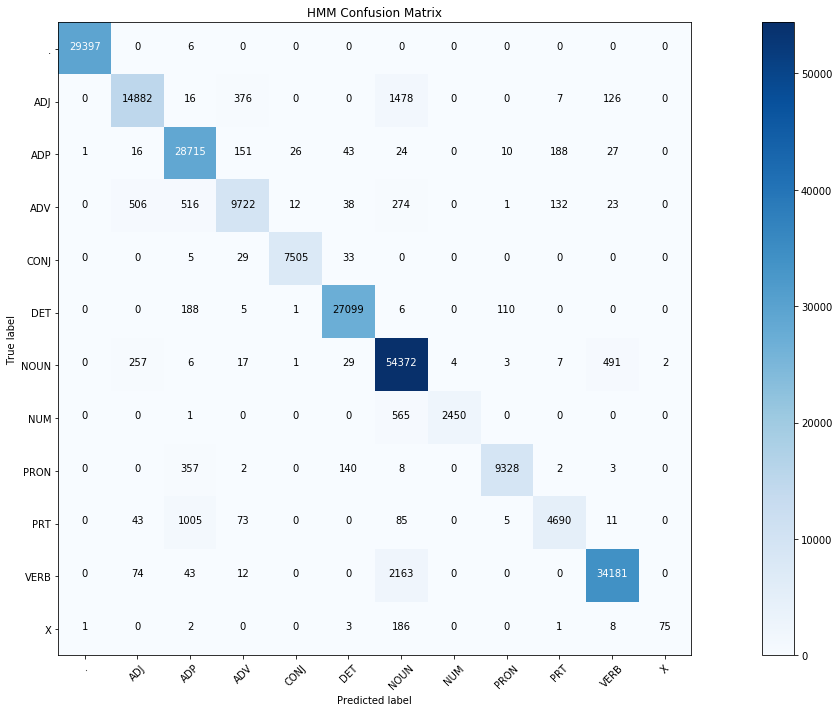

In [69]:
# build a hmm confusion matrix based on test predictions
y_test = []
y_pred = []
for i,nrows in df_test.iterrows():
    for num,wrd in enumerate(nrows['words']):
        y_test.append(nrows['pos_target'][num])
        y_pred.append(nrows['hmm_pred'][num])
#compute       
cm = confusion_matrix(y_test, y_pred)
#normalize
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#format
np.set_printoptions(precision=2)
#plot
plt.figure(figsize=(20,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('HMM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(pos_types))
plt.xticks(tick_marks, pos_types, rotation=45)
plt.yticks(tick_marks, pos_types)
#fmt = '.2f'
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [70]:
# generate classification report for test predictions
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29403
         ADJ       0.94      0.88      0.91     16885
         ADP       0.93      0.98      0.96     29201
         ADV       0.94      0.87      0.90     11224
        CONJ       0.99      0.99      0.99      7572
         DET       0.99      0.99      0.99     27409
        NOUN       0.92      0.99      0.95     55189
         NUM       1.00      0.81      0.90      3016
        PRON       0.99      0.95      0.97      9840
         PRT       0.93      0.79      0.86      5912
        VERB       0.98      0.94      0.96     36473
           X       0.97      0.27      0.42       276

   micro avg       0.96      0.96      0.96    232400
   macro avg       0.97      0.87      0.90    232400
weighted avg       0.96      0.96      0.96    232400



### (20) Comparison between MFC and HMM taggers.
The HMM is about 1.3% more accurate than the MFC on the training set.  
The HMM is about 1.3% more accurate than the MFC on the testing set.   

However, accuracy depends upon the part of speech tag type.  
Relatively low f1-scores are found on some of the part of speech tags.  
X, PRT, NUM, ADV, and ADJ part of speech types tend to score lower.